In [1]:
from concurrent.futures import ThreadPoolExecutor
from typing import List, Tuple
import colorsys
import numpy as np
import matplotlib.pyplot as plt
import sk_dsp_comm.sigsys as ss
from nptyping import Complex128, Float64, Int64, NDArray, Shape  # type: ignore
from scipy.signal import find_peaks
import matplotlib.colors as colors

NP1DF8 = NDArray[Shape["*"], Float64]
NP2DF8 = NDArray[Shape["*,*"], Float64]
NP1DC16 = NDArray[Shape["*"], Complex128]
NP2DC16 = NDArray[Shape["*,*"], Complex128]
TT_TYPE = NDArray[Shape["10"], Int64]

def filter_negWaveVectors(M_yx: NP2DC16) -> NP2DC16:
    M_kq = np.fft.fft2(M_yx)
    kLen = int(M_kq.shape[1] / 2 + 1)
    zeros = np.zeros((M_kq.shape[0], kLen))
    M_kq[:, :kLen] = zeros
    M_yx_filtered = np.fft.ifft2(M_kq)
    M_yx_filtered /= np.amax(
        np.abs(M_yx_filtered[:, int(M_yx_filtered.shape[1] / 2 + 100)])
    )
    return M_yx_filtered

def initialize_point_src() -> NP2DC16:
    M_oop = np.load("./point_source_yig/point_source_2600_MHz_200_mT_OOP.npz")["M"]
    pointSrc0 = filter_negWaveVectors(M_oop)
    return pointSrc0[:, int(pointSrc0.shape[1] / 2) :]

def generate_rectangular_function(
    distance_between_inputs: int,
    unit_cell_size: int,
    number_of_inputs: int,
    input_width: int,
) -> Tuple[NP1DF8, NP1DF8, float]:
    d = distance_between_inputs / unit_cell_size
    s = input_width / unit_cell_size
    width = d * number_of_inputs
    x_int = np.arange(0, width, 1)
    rec = ss.rect(np.mod(x_int, d) - d / 2, s)
    return rec, x_int, d

def calculate_analytic_signal(
    g_in: NP1DF8,
    x_int: NP1DF8,
    changed_src_numbers: List[int],
    input_phase_shift: float,
    active_input_amplitude: float,
):
    g_in_an = np.zeros_like(x_int, dtype=complex)
    b = 1
    for i in range(len(x_int)):
        if g_in[i] == 1 and (b in changed_src_numbers):
            phi_t = input_phase_shift
            Amp = active_input_amplitude
            if g_in[i + 1] == 0:
                b += 1
        elif g_in[i] == 1:
            phi_t = 0
            Amp = 1
            if g_in[i + 1] == 0:
                b += 1
        else:
            phi_t = 0
            Amp = 1
        g_in_an[i] = Amp * g_in[i] * np.exp(1j * phi_t)
    return g_in_an

def convolve_column(pointSrc: NP2DC16, g_in: NP1DC16, i: int) -> NP1DC16:
    return np.convolve(pointSrc[:, i], g_in, mode="full")

def convolve_columns(pointSrc: NP2DC16, g_in: NP1DC16) -> NP2DC16:
    newField = np.empty(
        (pointSrc.shape[0] + g_in.shape[0] - 1, pointSrc.shape[1]), dtype=np.complex128
    )
    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(convolve_column, pointSrc, g_in, i)
            for i in range(pointSrc.shape[1])
        ]
        for i, future in enumerate(futures):
            newField[:, i] = future.result()
    return newField

def normalize_and_slice_field(
    newField: NP2DC16,
    pointSrc: NP2DC16,
    axhl: int,
) -> NP2DF8:
    newField2 = np.abs(newField) ** 2
    newField2 = newField2[
        int(pointSrc.shape[0] / 2) : -int(pointSrc.shape[0] / 2), : int(1.5*axhl)
    ]
    return newField2

def calculate_truth_table(
    distance_between_inputs: float,
    max_i: List[float], 
    number_of_inputs: int,
    input_width: int,
    unite_cell_size: int
    ) -> TT_TYPE:
    truth_table = np.zeros(number_of_inputs-1)
    for i in range(0, number_of_inputs-1):
        if any((i+0.5)*distance_between_inputs + input_width/2
               <= element*unite_cell_size <= 
               (i+1.5)*distance_between_inputs - input_width/2 for element in max_i):
            truth_table[i] = 1
    return truth_table

def get_talbot_length(
    distance_between_inputs: int,  # nm
    wavelength: float, # nm
    input_width: int,  # nm
    unit_cell_size: int,  # nm
):
    if (
        distance_between_inputs % unit_cell_size != 0
        or input_width % unit_cell_size != 0
    ):
        raise ValueError(
            f"All length parameters must be divisible by {unit_cell_size}."
        )

    # round to the nearest multiple of unit_cell_size
    talbot_length = (
        (1 * distance_between_inputs**2 / wavelength) // unit_cell_size * unit_cell_size
    )
    return talbot_length

def colourMode(mod, phase):
    mod = mod/np.amax(mod)
    array1 = np.zeros((phase.shape[0], phase.shape[1], 3))
    for y in range(phase.shape[0]):
        for x in range(phase.shape[1]):
            h = 0.5+phase[y,x]/(2*np.pi)  # angle
            l, s = (mod[y,x]), 1
            array1[y,x] = np.array(colorsys.hls_to_rgb(h, l, s))
    return array1

def logic_oop(
    number_of_inputs: int,
    distance_between_inputs: int,  # nm
    input_width: int,  # nm
    active_inputs: List[int],
    active_input_phase_shift: float,
    active_input_amplitude: float,
    wavelength: float,  # nm
    unit_cell_size: int,  # nm
    offset: int,
    w_axhl: int,
    plots: bool = True,
    one_d_phase: bool = False,
):
    
    talbot_length = get_talbot_length(
        distance_between_inputs, wavelength, input_width, unit_cell_size
    )
    
    input_output_distance = talbot_length - offset
    axhl = int(input_output_distance // unit_cell_size)

    pointSrc: NP2DC16 = initialize_point_src()

    g_in, x_int, d = generate_rectangular_function(
        distance_between_inputs,
        unit_cell_size,
        number_of_inputs,
        input_width,
    )

    g_in_c: NP1DC16 = calculate_analytic_signal(
        g_in,
        x_int,
        active_inputs,
        active_input_phase_shift,
        active_input_amplitude,
    )

    newField: NP2DC16 = convolve_columns(pointSrc, g_in_c)
    intensity: NP2DF8 = normalize_and_slice_field(
        newField, pointSrc, axhl)
    intensity /= np.amax(np.abs(intensity[:, 20:]))
    
    int_avg: NP1DF8 = np.mean(intensity[:, axhl - w_axhl : axhl + w_axhl], axis=1)
    threshold = 0.8*int_avg.max()
    max_i: List[float] = find_peaks(int_avg, height=threshold)[0]

    truth_table = calculate_truth_table(distance_between_inputs, max_i, number_of_inputs, input_width, unit_cell_size)
    
    if plots:
        phase_2plot = np.angle(newField[int(pointSrc.shape[0] / 2) : -int(pointSrc.shape[0] / 2), : int(1.5*axhl)])
        mod_2plot = np.abs(newField[int(pointSrc.shape[0] / 2) : -int(pointSrc.shape[0] / 2), : int(1.5*axhl)])
        intentsity_1d_x = np.arange(0, intensity.shape[0], 1)
        int_avg = np.mean(intensity[:, axhl - w_axhl:axhl + w_axhl], axis=1)
        phase_1d_x = np.arange(0, intensity.shape[0], 1)
        phase_1d = phase_2plot[:, axhl]
        max_i = find_peaks(int_avg, height=threshold)[0]
        
        f, ax = plt.subplots(2, 2, gridspec_kw={'height_ratios': [1, 4]}, sharex=True, figsize=(12, 5))

        ax[0, 0].plot(x_int*unit_cell_size, np.abs(g_in_c), color='k')
        ax[0, 0].fill_between(x_int*unit_cell_size, 0, np.abs(g_in_c), color='#CCCCCC')
        ax[0, 0].set_ylim(-0.1, 1.1)
        ax[0, 0].set_ylabel("Amplitude")
        ax0a = ax[0, 0].twinx()
        ax0a.plot(x_int*unit_cell_size, np.angle(g_in_c) * 180 / np.pi, color='maroon', ls='-', lw=4)
        ax0a.tick_params(axis='y', labelcolor='maroon')
        ax0a.set_ylabel("Phase (°)", color='maroon')
        ax0a.set_ylim(-190, 190)
        ax0a.set_yticks(range(-180, 190, 90))
        
        ax[1, 0].imshow(colourMode(mod_2plot.T, phase_2plot.T), aspect='auto', interpolation='sinc', extent=[0, len(intentsity_1d_x)*unit_cell_size, 1.5*axhl*unit_cell_size, 0])
        ax[1, 0].set_xlabel("x (nm)")
        ax[1, 0].set_ylabel("y (nm)")
        
        ax[0, 1].set_ylim(0, 1)
        ax[0, 1].plot(intentsity_1d_x*unit_cell_size, int_avg, linewidth=3, color='blue')
        ax[0, 1].set_ylabel("Amplitude")
        # ax[0, 1].axhline(threshold, color='orange', ls='--')
        # for i in range(0, number_of_inputs-1):
        #     ax[0, 1].text(distance_between_inputs/unit_cell_size * ((i+0.5)*unit_cell_size), 0.8, f"{int(truth_table[i])}", color='black', fontsize=12, ha='center')
        # for i in range(0, number_of_inputs+1):
        #     ax[0, 1].axvline(distance_between_inputs/unit_cell_size * ((i-1)*unit_cell_size), color='orange', lw=2, alpha=0.4)
        # for j in max_i:
        #     ax[0, 1].scatter(j*unit_cell_size, int_avg[j], zorder=3, color='red')
        
        ax[1, 1].imshow(intensity.T, norm=colors.Normalize(vmin=0, vmax=1), aspect='auto', extent=[0, len(intentsity_1d_x)*unit_cell_size, 1.5*axhl*unit_cell_size, 0])
        ax[1, 1].axhline(axhl, color='red', lw=w_axhl, alpha=0.4)
        ax[1, 1].set_xlabel("x (nm)")
        ax[1, 1].set_ylabel("y (nm)")
        # for i in range(1, number_of_inputs+1):
            # ax[1, 1].axvline(distance_between_inputs/unit_cell_size * ((i+0.5)*unit_cell_size), color='yellow', lw=2, alpha=0.4, ymin=0.2, ymax=0.5)
        
        if one_d_phase:
            ax0b = ax[0, 1].twinx()
            ax0b.plot(phase_1d_x*unit_cell_size, phase_1d * 180 / np.pi, linewidth=1, color='maroon')
            ax0b.set_ylabel("Phase (°)", color='maroon')
            ax0b.set_ylim(-190, 190)
            ax0b.set_yticks(range(-180, 190, 90))
            ax0b.tick_params(axis='y', labelcolor='maroon')
            
        plt.tight_layout()
        plt.show()

    return truth_table

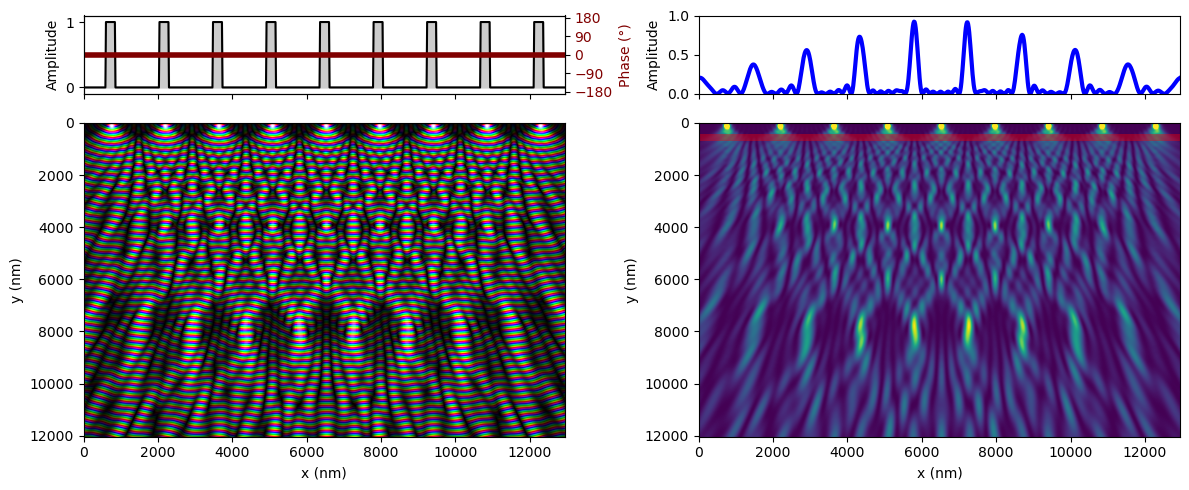

In [2]:
if __name__ == "__main__":
    tt = logic_oop(
        number_of_inputs=9,
        distance_between_inputs=1440,  # nm
        input_width=240,  # nm
        active_inputs=[],
        active_input_phase_shift=np.pi/2,
        active_input_amplitude=1,  # 1 -> unchanged
        wavelength=232,  # nm
        unit_cell_size=15,  # nm
        offset=900,  # nm
        w_axhl=5,
        plots=True,
        one_d_phase=False
    )

[0, 1, 0, 1, 1, 0, 1, 0, 0]


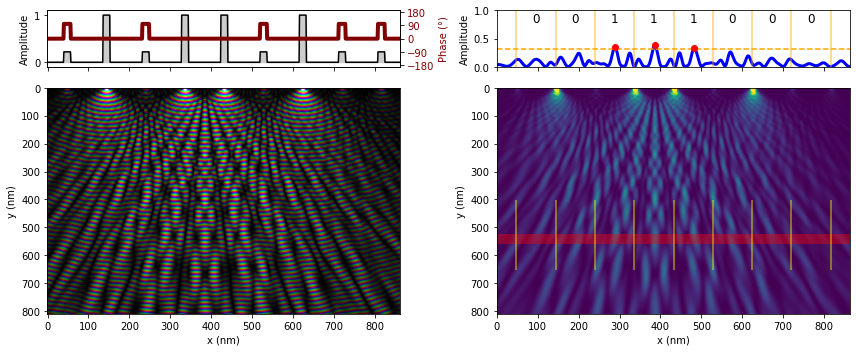

[0. 0. 1. 1. 1. 0. 0. 0.]


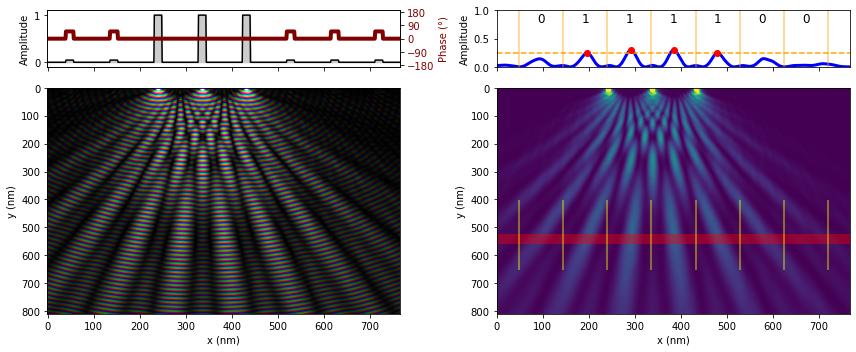

[0. 1. 1. 1. 1. 0. 0.]


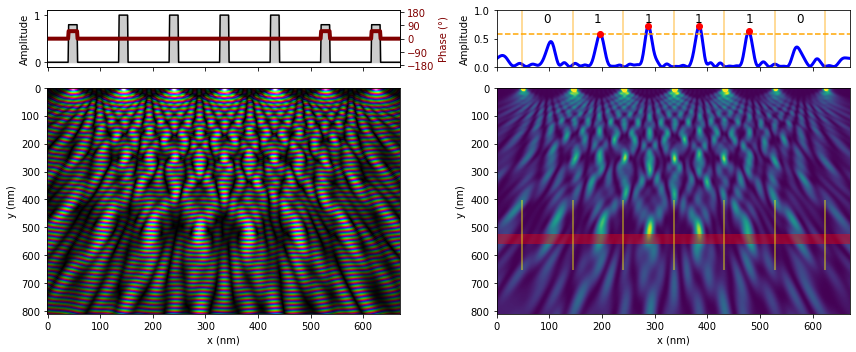

[0. 1. 1. 1. 1. 0.]


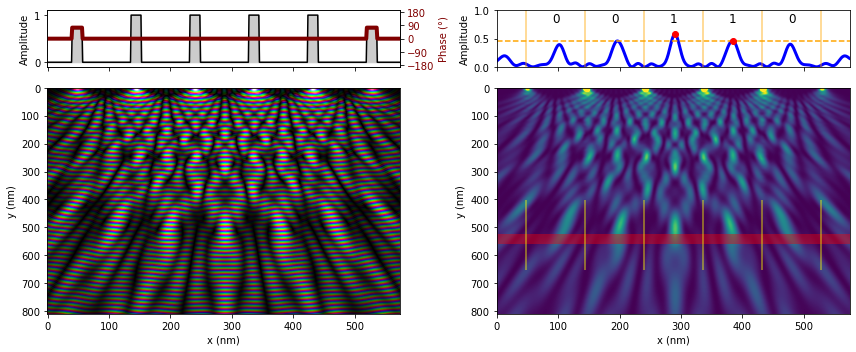

[0. 0. 1. 1. 0.]


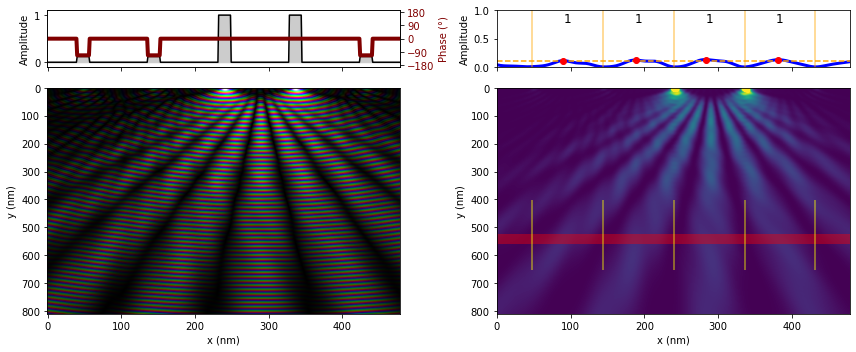

[1. 1. 1. 1.]


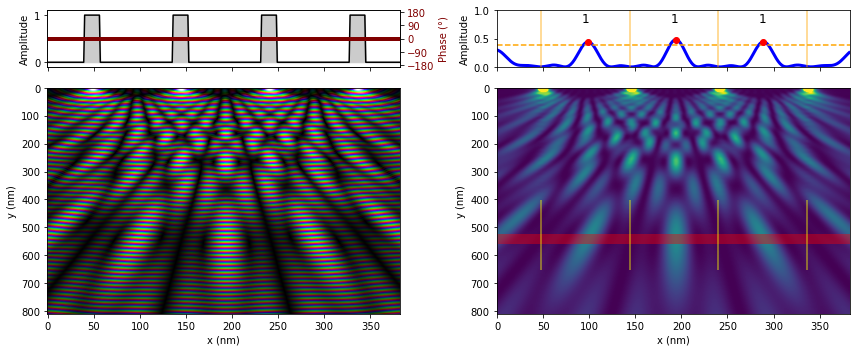

[1. 1. 1.]


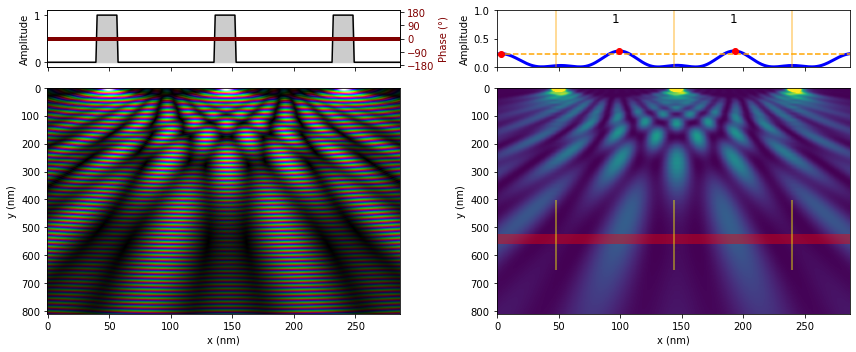

[1. 1.]


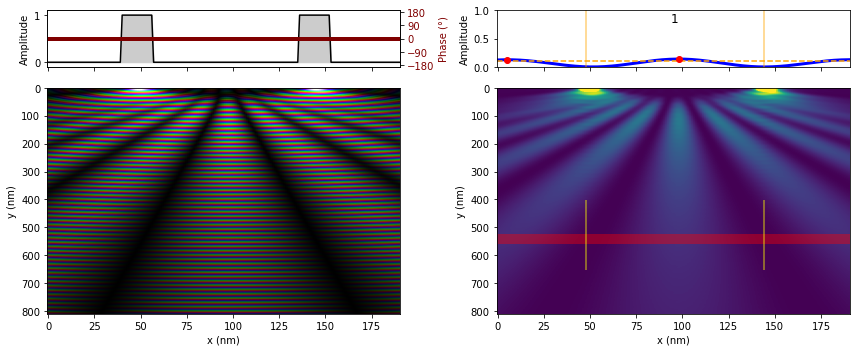

[1.]


In [4]:
tt=[0,1,0,1,1,0,1,0,0]
print(tt)
for i in range(1,9):
    if __name__ == "__main__":
        tt = logic_oop(
        number_of_inputs=10-i,
        distance_between_inputs=1440,  # nm
        input_width=240,  # nm
        active_inputs=[index+1 for index, value in enumerate(tt) if value != 1],
        active_input_phase_shift=np.random.uniform(-np.pi, np.pi),
        active_input_amplitude=np.random.uniform(0,1),  # 1 -> unchanged
        wavelength=230.24,  # nm
        unit_cell_size=15,  # nm
        offset=900,  # nm
        w_axhl=10,
        plots=True,
        one_d_phase=False
        )
    print(tt)

[0, 1, 0, 1, 1, 0, 1, 0, 0]


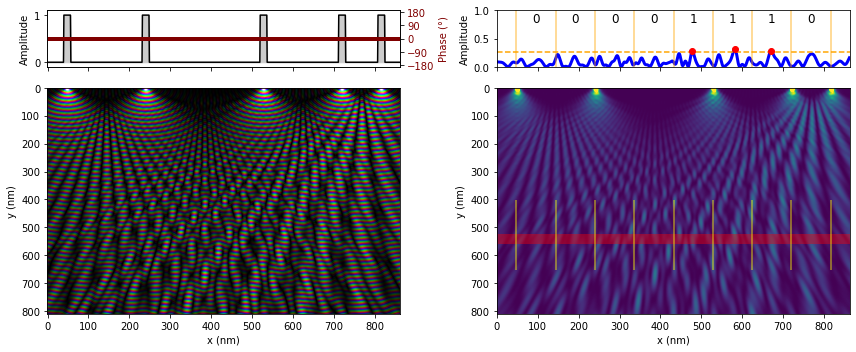

[0. 0. 0. 0. 1. 1. 1. 0.]


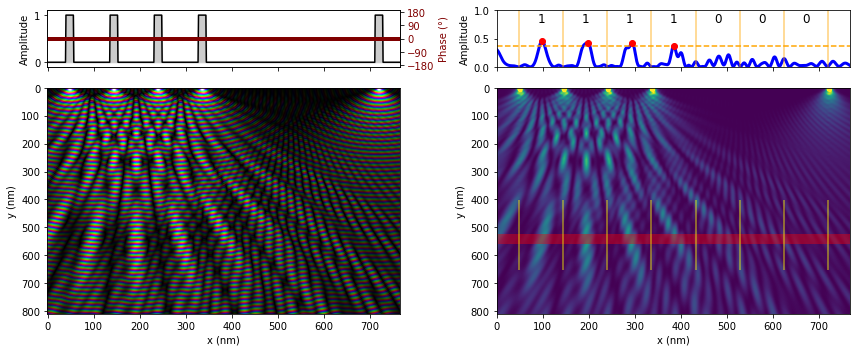

[1. 1. 1. 1. 0. 0. 0.]


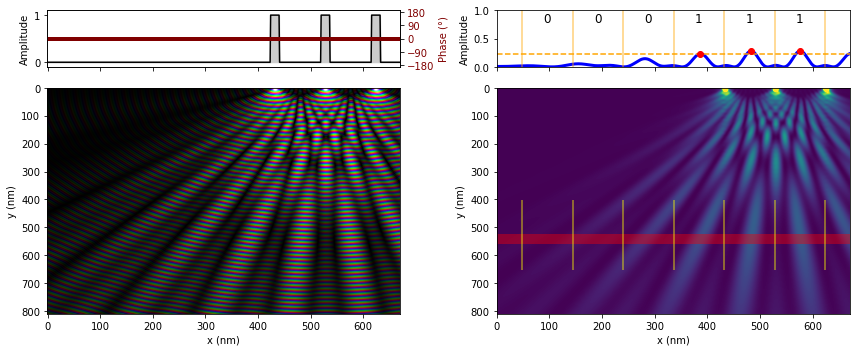

[0. 0. 0. 1. 1. 1.]


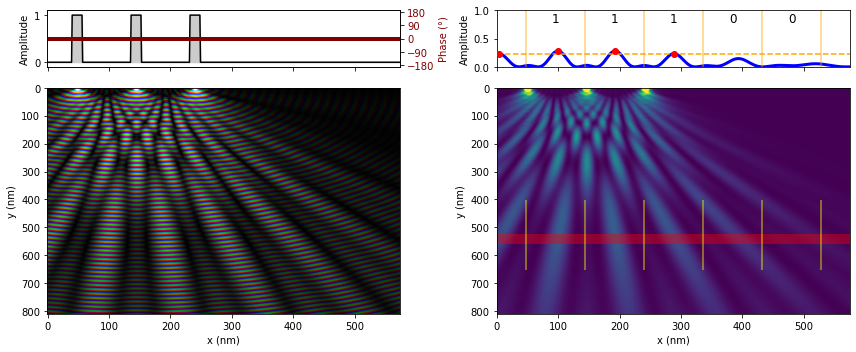

[1. 1. 1. 0. 0.]


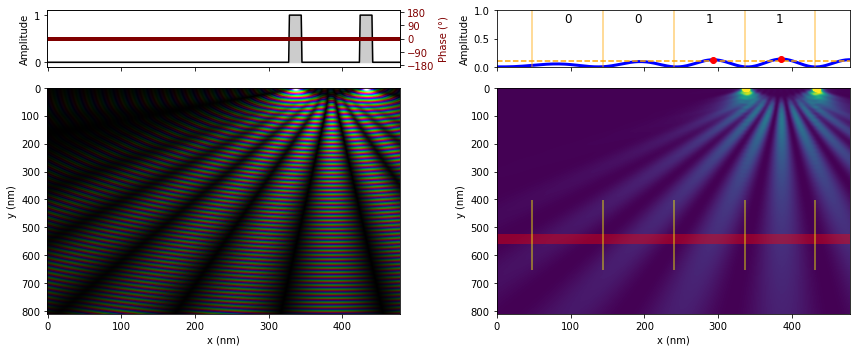

[0. 0. 1. 1.]


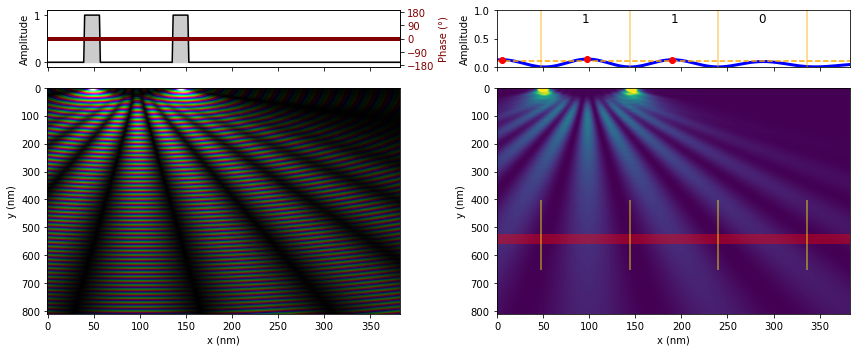

[1. 1. 0.]


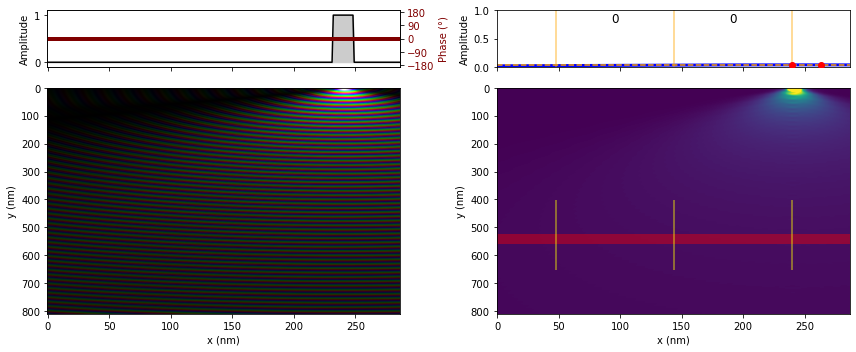

[0. 0.]


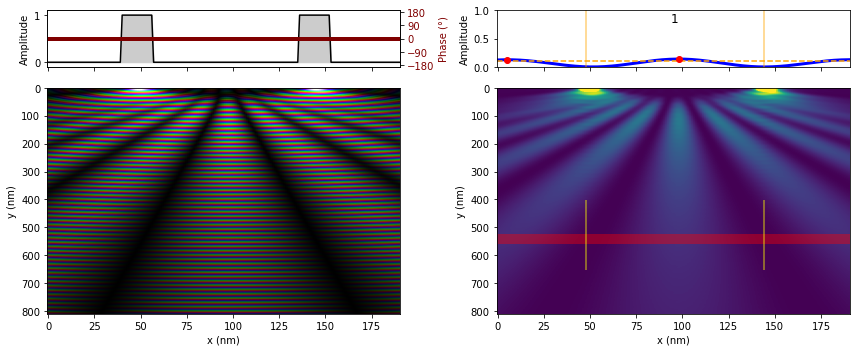

[1.]


In [5]:
tt=[0,1,0,1,1,0,1,0,0]
print(tt)
for i in range(1,9):
    if __name__ == "__main__":
        tt = logic_oop(
        number_of_inputs=10-i,
        distance_between_inputs=1440,  # nm
        input_width=240,  # nm
        active_inputs=[index+1 for index, value in enumerate(tt) if value != 0],
        active_input_phase_shift=0,
        active_input_amplitude=0,  # 1 -> unchanged
        wavelength=230.24,  # nm
        unit_cell_size=15,  # nm
        offset=900,  # nm
        w_axhl=10,
        plots=True,
        one_d_phase=False
        )
    print(tt)

In [22]:
while True:
    tt=[0,1,1,0,0,1,1,0,0]
    print(tt)
    while sum(tt)!=1:
        if __name__ == "__main__":
            tt = logic_oop(
            number_of_inputs=10,
            distance_between_inputs=1440,  # nm
            input_width=240,  # nm
            active_inputs=[index+1 for index, value in enumerate(tt) if value != 0],
            active_input_phase_shift=np.pi/2,
            active_input_amplitude=np.random.uniform(0, 1),  # 1 -> unchanged
            wavelength=230.24,  # nm
            unit_cell_size=15,  # nm
            offset=900,  # nm
            w_axhl=10,
            plots=False,
            one_d_phase=False
            )
        print(tt)

[0, 1, 1, 0, 0, 1, 1, 0, 0]
[0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0, 1, 1, 0, 0, 1, 1, 0, 0]
[0. 0. 1. 1. 1. 0. 1. 1. 0.]
[0. 1. 0. 0. 0. 1. 0. 1. 1.]
[0. 0. 1. 1. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 1. 1. 1. 1. 0.]
[1. 1. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 1. 1. 0. 0.]
[1. 1. 1. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 1. 1. 1. 1. 0.]
[0. 0. 1. 1. 0. 1. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 1. 0.]
[0. 1. 1. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0, 1, 1, 0, 0, 1, 1, 0, 0]
[0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0, 1, 1, 0, 0, 1, 1, 0, 0]
[0. 0. 1. 1. 1. 0. 1. 1. 0.]
[0. 1. 0. 0. 0. 1. 0. 1. 1.]
[0. 0. 1. 1. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 1. 0.]
[0. 1. 1. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0, 1, 1, 0, 0, 1, 1, 0, 0]
[0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0, 1, 1, 0, 0, 1, 1, 0, 0]
[0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0, 1, 1, 0, 0, 1, 1, 0, 0]
[0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0, 1, 1, 0, 0, 1, 1, 0, 0]
[0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0, 1, 1, 0, 0, 1, 1, 0, 0]
[0. 0. 0. 0. 0. 0. 1. 1. 0.]
[0. 1. 1. 1. 0. 0. 0. 0

KeyboardInterrupt: 

In [24]:
import itertools

def inputs_combinations(number_of_inputs):

    all_combinations_digit = []
    all_combinations_numb = []
    a_list = []
    
    for i in range(number_of_inputs):
        a_list.append(i+1)

    for r in range(len(a_list)+1):
        combinations_object = itertools.combinations(a_list, r)
        combinations_list = list(combinations_object)
        all_combinations_numb+=combinations_list
    all_combinations_numb=all_combinations_numb[1:]
    
    for i in range(len(all_combinations_numb)):
        if len(all_combinations_numb[i])==1:
            all_combinations_numb[i]=(all_combinations_numb[i][0])
    # print(all_combinations)

    for i in range(len(all_combinations_numb)):
        inputs = [0]*number_of_inputs
        if type(all_combinations_numb[i])==int:
            inputs[all_combinations_numb[i]-1]=1
            all_combinations_numb[i] = [all_combinations_numb[i]]
        else:
            for j in range(len(list(all_combinations_numb[i]))):
                inputs[list(all_combinations_numb[i])[j]-1]=1
                all_combinations_numb[i] = list(all_combinations_numb[i])
        all_combinations_digit.append(inputs)
    return all_combinations_digit, all_combinations_numb

In [25]:
number_of_inputs = 4
L = len(inputs_combinations(number_of_inputs)[0])
for i in range(L):
        print(inputs_combinations(number_of_inputs)[1][i],' --------> ',inputs_combinations(number_of_inputs)[0][i])

[1]  -------->  [1, 0, 0, 0]
[2]  -------->  [0, 1, 0, 0]
[3]  -------->  [0, 0, 1, 0]
[4]  -------->  [0, 0, 0, 1]
[1, 2]  -------->  [1, 1, 0, 0]
[1, 3]  -------->  [1, 0, 1, 0]
[1, 4]  -------->  [1, 0, 0, 1]
[2, 3]  -------->  [0, 1, 1, 0]
[2, 4]  -------->  [0, 1, 0, 1]
[3, 4]  -------->  [0, 0, 1, 1]
[1, 2, 3]  -------->  [1, 1, 1, 0]
[1, 2, 4]  -------->  [1, 1, 0, 1]
[1, 3, 4]  -------->  [1, 0, 1, 1]
[2, 3, 4]  -------->  [0, 1, 1, 1]
[1, 2, 3, 4]  -------->  [1, 1, 1, 1]


In [26]:
number_of_inputs = 9
L = len(inputs_combinations(number_of_inputs)[0])
for i in range(L):
    tt_out = number_of_inputs*[0]
    tt_in = inputs_combinations(number_of_inputs)[0][i]
    count = 0
    print('INPUT: ', tt_in)
    while sum(tt_out)!=1:
        tt_out = logic_oop(
        number_of_inputs=number_of_inputs,
        distance_between_inputs=1440,  # nm
        input_width=240,  # nm
        active_inputs=[index+1 for index, value in enumerate(tt_in) if value != 0],
        active_input_phase_shift=np.pi/2,
        active_input_amplitude=np.random.uniform(0, 1),  # 1 -> unchanged
        wavelength=230.24,  # nm
        unit_cell_size=15,  # nm
        offset=900,  # nm
        w_axhl=10,
        plots=False,
        one_d_phase=False
        )
        print('output: ', tt_out)
        tt_in = tt_out
        count += 1

    print(f'"1" at {list(tt_out).index(1)} position: ', tt_out)
    print('number of iterations: ', count)
    print('---------------------------------')

INPUT:  [1, 0, 0, 0, 0, 0, 0, 0, 0]
output:  [0. 0. 0. 0. 1. 1. 0. 0.]
output:  [0. 0. 1. 0. 0. 0. 0. 0.]
"1" at 2 position:  [0. 0. 1. 0. 0. 0. 0. 0.]
number of iterations:  2
---------------------------------
INPUT:  [0, 1, 0, 0, 0, 0, 0, 0, 0]
output:  [0. 0. 0. 1. 1. 1. 0. 0.]
output:  [0. 1. 1. 0. 0. 1. 1. 0.]
output:  [0. 0. 0. 0. 1. 1. 1. 0.]
output:  [1. 1. 1. 0. 0. 0. 0. 0.]
output:  [0. 0. 0. 1. 1. 1. 1. 0.]
output:  [0. 0. 1. 0. 0. 0. 0. 0.]
"1" at 2 position:  [0. 0. 1. 0. 0. 0. 0. 0.]
number of iterations:  6
---------------------------------
INPUT:  [0, 0, 1, 0, 0, 0, 0, 0, 0]
output:  [0. 0. 0. 1. 1. 0. 1. 0.]
output:  [0. 1. 0. 0. 0. 0. 0. 0.]
"1" at 1 position:  [0. 1. 0. 0. 0. 0. 0. 0.]
number of iterations:  2
---------------------------------
INPUT:  [0, 0, 0, 1, 0, 0, 0, 0, 0]
output:  [0. 0. 0. 1. 1. 1. 0. 0.]
output:  [0. 1. 1. 0. 0. 1. 1. 0.]
output:  [0. 0. 1. 1. 0. 0. 0. 0.]
output:  [0. 0. 0. 1. 1. 1. 1. 1.]
output:  [1. 1. 1. 0. 0. 0. 0. 0.]
output:  [0. 0. 

KeyboardInterrupt: 

In [11]:
import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output

matrix = np.random.randint(2, size=(3,3))

buttons = [[widgets.Button(description=str(val), 
                           layout=widgets.Layout(width='60px', height='60px', border='1px solid black'), 
                           style=widgets.ButtonStyle(button_color='black' if val == 1 else 'white', font_weight='bold')) 
            for val in row] for row in matrix]

def on_button_click(button):
    x, y = button.x, button.y
    matrix[x, y] = 1 - matrix[x, y] 
    button.description = str(matrix[x, y]) 
    button.style.button_color = 'black' if matrix[x, y] == 1 else 'white'

positions=[]
for i, row in enumerate(buttons):
    for j, button in enumerate(row):
        button.x = i
        button.y = j
        button.on_click(on_button_click)

for row in buttons:
    display(widgets.HBox(row))

ok_button = widgets.Button(description="OK", layout=widgets.Layout(width='60px', height='30px'), 
                            style=widgets.ButtonStyle(button_color='lightblue', font_weight='bold'))

display(ok_button)

def on_ok_button_click(button):
    global positions
    print(matrix)
    indices = np.where(matrix == 1)
    positions = [i * matrix.shape[1] + j + 1 for i, j in zip(*indices)]
    print(positions)
    # return positions
    # output=logic_oop(9, 360, 230, positions, 0, 0, int(talbot_length(360,lambda_oop)), 0.4, 1, True)
    # print(output)
    
ok_button.on_click(on_ok_button_click)

Button(description='OK', layout=Layout(height='30px', width='60px'), style=ButtonStyle(button_color='lightblue…

[[0 1 0]
 [1 1 1]
 [0 0 0]]
[2, 4, 5, 6]


In [12]:
print(positions)

[2, 4, 5, 6]


In [23]:
number_of_inputs = 9
L = len(inputs_combinations(number_of_inputs)[0])
for i in range(L):
    tt_out = number_of_inputs*[0]
    tt_in = inputs_combinations(number_of_inputs)[0][i]
    count = 0
    print('INPUT: ', tt_in)
    while sum(tt_out)!=1:
        tt_out = logic_oop(
        number_of_inputs=number_of_inputs,
        distance_between_inputs=1440,  # nm
        input_width=240,  # nm
        active_inputs=[index+1 for index, value in enumerate(tt_in) if value != 0],
        active_input_phase_shift=np.pi/2,
        active_input_amplitude=np.random.uniform(0, 1),  # 1 -> unchanged
        wavelength=230.24,  # nm
        unit_cell_size=15,  # nm
        offset=900,  # nm
        w_axhl=10,
        plots=False,
        one_d_phase=False
        )
        print('output: ', tt_out)
        tt_in = tt_out
        count += 1

    print(f'"1" at {list(tt_out).index(1)} position: ', tt_out)
    print('number of iterations: ', count)
    print('---------------------------------')

NameError: name 'inputs_combinations' is not defined

In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Assuming inputs_combinations and logic_oop functions are defined

# Generate a smaller dataset for quick processing
number_of_inputs = 9
L = len(inputs_combinations(number_of_inputs)[0])
data = []
labels = []

# Use a smaller subset of the data for quick testing
subset_size = 100  # Adjust this value as needed for quick testing
for i in range(min(subset_size, L)):
    tt_out = number_of_inputs * [0]
    tt_in = inputs_combinations(number_of_inputs)[0][i]
    count = 0
    while sum(tt_out) != 1:
        tt_out = logic_oop(
            number_of_inputs=number_of_inputs,
            distance_between_inputs=1440,  # nm
            input_width=240,  # nm
            active_inputs=[index + 1 for index, value in enumerate(tt_in) if value != 0],
            active_input_phase_shift=np.pi / 2,
            active_input_amplitude=np.random.uniform(0, 1),  # 1 -> unchanged
            wavelength=230.24,  # nm
            unit_cell_size=15,  # nm
            offset=900,  # nm
            w_axhl=10,
            plots=False,
            one_d_phase=False
        )
        tt_in = tt_out
        count += 1
    index_of_one = list(tt_out).index(1)
    data.append(tt_in)
    labels.append(index_of_one)

data = np.array(data)
labels = np.array(labels).reshape(-1, 1)

# One-hot encode labels
encoder = OneHotEncoder(sparse=False)
labels = encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Define PyTorch Dataset
class LogicDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

train_dataset = LogicDataset(X_train, y_train)
test_dataset = LogicDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verify the shape of the input data
for data, labels in train_loader:
    print(f"Shape of input data: {data.shape}")
    break

# Define the model
class LogicModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogicModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=1)
        return x

# Adjust the input size based on the actual shape of the data
input_size = data.shape[1]
model = LogicModel(input_size=input_size, output_size=number_of_inputs)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 5  # Reduce the number of epochs for quick testing
for epoch in range(num_epochs):
    model.train()
    for data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, torch.argmax(labels, dim=1))
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, labels in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

# Save the model
torch.save(model.state_dict(), 'index_recognition_model.pth')

KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn as nn

# Define the model class (same as the one used during training)
class LogicModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogicModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=1)
        return x

# Load the model
input_size = 8  # Input size used during training
output_size = 9  # Output size used during training
model = LogicModel(input_size=input_size, output_size=output_size)
model.load_state_dict(torch.load('index_recognition_model.pth'))
model.eval()

# Function to test the model on new data
def test_model(model, new_data):
    # Ensure the new data is a torch tensor
    new_data = torch.tensor(new_data, dtype=torch.float32)
    
    # Make predictions
    with torch.no_grad():
        outputs = model(new_data)
        _, predicted = torch.max(outputs.data, 1)
    
    return predicted

# Example new data (replace with actual new data)
new_data = [
    [0, 1, 0, 1, 0, 1, 0, 1],  # Example input
    [1, 0, 1, 0, 1, 0, 1, 0]   # Another example input
]

# Test the model
predictions = test_model(model, new_data)
print(f'Predictions: {predictions.numpy()}')

Predictions: [3 0]


Shape of input data: torch.Size([32, 8])
Epoch [1/10], Loss: 2.1989
Epoch [2/10], Loss: 2.1941
Epoch [3/10], Loss: 2.1887
Epoch [4/10], Loss: 2.1831
Epoch [5/10], Loss: 2.1771
Epoch [6/10], Loss: 2.1711
Epoch [7/10], Loss: 2.1634
Epoch [8/10], Loss: 2.1539
Epoch [9/10], Loss: 2.1435
Epoch [10/10], Loss: 2.1327


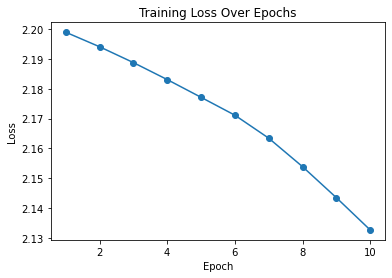

Test Accuracy: 90.00%


In [15]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt

# Assuming inputs_combinations and logic_oop functions are defined

# Generate a smaller dataset for quick processing
number_of_inputs = 9
L = len(inputs_combinations(number_of_inputs)[0])
data = []
labels = []

# Use a smaller subset of the data for quick testing
subset_size = 100  # Adjust this value as needed for quick testing
for i in range(min(subset_size, L)):
    tt_out = number_of_inputs * [0]
    tt_in = inputs_combinations(number_of_inputs)[0][i]
    count = 0
    while sum(tt_out) != 1:
        tt_out = logic_oop(
            number_of_inputs=number_of_inputs,
            distance_between_inputs=1440,  # nm
            input_width=240,  # nm
            active_inputs=[index + 1 for index, value in enumerate(tt_in) if value != 0],
            active_input_phase_shift=np.pi / 2,
            active_input_amplitude=np.random.uniform(0, 1),  # 1 -> unchanged
            wavelength=230.24,  # nm
            unit_cell_size=15,  # nm
            offset=900,  # nm
            w_axhl=10,
            plots=False,
            one_d_phase=False
        )
        tt_in = tt_out
        count += 1
    index_of_one = list(tt_out).index(1)
    data.append(tt_in)
    labels.append(index_of_one)

data = np.array(data)
labels = np.array(labels).reshape(-1, 1)

# One-hot encode labels
encoder = OneHotEncoder(sparse=False)
labels = encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Define PyTorch Dataset
class LogicDataset(Dataset):
    def __init__(self, data, labels):
        self.data = torch.tensor(data, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

train_dataset = LogicDataset(X_train, y_train)
test_dataset = LogicDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Verify the shape of the input data
for data, labels in train_loader:
    print(f"Shape of input data: {data.shape}")
    break

# Define the model
class LogicModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogicModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.softmax(self.fc3(x), dim=1)
        return x

# Adjust the input size based on the actual shape of the data
input_size = data.shape[1]
model = LogicModel(input_size=input_size, output_size=number_of_inputs)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training
num_epochs = 10  # Reduce the number of epochs for quick testing
losses = []
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for data, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, torch.argmax(labels, dim=1))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= len(train_loader)
    losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

# Plot the training loss
plt.plot(range(1, num_epochs + 1), losses, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.show()

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, labels in test_loader:
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == torch.argmax(labels, dim=1)).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

# Save the model
torch.save(model.state_dict(), 'index_recognition_model.pth')